In [1]:
#Import all libraries that are required
%matplotlib inline

import numpy as np
import pandas as pd
# pd.options.display.float_formatrmat = '${:,.2f}'.format
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
from wordcloud import WordCloud

from io import BytesIO
from requests import get
from PIL import Image, ImageDraw
import instaloader
import pymongo

from pandas.io.json import json_normalize
import json

#NECESSARY FOR XTICKS OPTION, ETC.
from pylab import*
from itertools import dropwhile, takewhile
import collections
import requests
import base64

import ast


import nltk
from ast import literal_eval
from datetime import timedelta
import string
import statistics
import itertools

from sklearn import preprocessing
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

import spacy
from nltk.tokenize.toktok import ToktokTokenizer
from bs4 import BeautifulSoup
# from contractions import CONTRACTION_MAP
import unicodedata


from functools import reduce
import operator
import json

import sys
sys.path.append('../')
import Variables as vr

[nltk_data] Downloading package stopwords to /home/koosha/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/koosha/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
# create loader object
L = instaloader.Instaloader()
LIST_ALL_USERS = vr.LIST_ALL_USERS

nltk.download('stopwords')
nltk.download('punkt')


USE_LOCAL_DA = True

if (not USE_LOCAL_DA):
    
    # MongoDB Database
    instagramClient = pymongo.MongoClient('157.159.68.107:27017',username='koosha',password='1123581321',authSource='Instagram')
    instagram_db = instagramClient["Instagram"]
    instagram_col_post = instagram_db["Post_impersonator_h"]
    instagram_col_comment = instagram_db["Comment_impersonator_h"]
    instagram_col_like = instagram_db["Like_impersonator_h"]
    instagram_col_impersonator = instagram_db["Imp_impersonator_h"]

else:

    # MongoDB Database
    Local_instagramClient = pymongo.MongoClient('127.0.0.1:27017',authSource='Instagram')
    instagram_db = Local_instagramClient["Instagram"]
    instagram_col_post = instagram_db["Post_impersonator_h"]
    instagram_col_comment = instagram_db["Comment_impersonator_h"]
    instagram_col_like = instagram_db["Like_impersonator_h"]
    instagram_col_impersonator = instagram_db["Imp_impersonator_h"]

[nltk_data] Downloading package stopwords to /home/koosha/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/koosha/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
# https://github.com/cjhutto/vaderSentiment#citation-information

# Load impersonator posts

In [29]:
df_clusters = pd.read_csv('Dataset/cluster_impersonator_2clusters.csv')

# with open('Dataset/cluster_impersonator_2clusters.json', 'r') as f:
#     data = json.load(f)
# df_clusters = pd.DataFrame(data)

df_clusters.shape[0]

842

In [30]:
df_clusters.columns

Index(['Unnamed: 0', 'user_id', 'avg comment', 'avg like', 'avg hashtag',
       'avg caption len', 'comment', 'like', 'caption', 'community', 'hashtag',
       '_id', 'username', 'mediacount', 'followers', 'followees', 'biography',
       'full_name', 'is_verified', 'is_private', 'external_url',
       'profile_pic_url', 'profile_image', 'associated_hashtag',
       'associated_username', 'similarity_username', 'similarity_full_name',
       'similarity_biography', 'similarity_photo', 'post', 'story',
       'highlight', 'relation_crawled', 'followee_list', 'follower_list',
       'external_url_value', 'lcm', 'mcm', 'nfollower', 'nfollowee',
       'nmediacount', 'nmcm', 'n avg comment', 'n avg like', 'n avg hashtag',
       'n avg caption len', 'cluster'],
      dtype='object')

In [31]:
# df_post = pd.read_csv('Dataset/post_data.csv')
# df_post.shape[0]

# convert list represantion to real list - problem with csv load

In [32]:
def convert_representations_to_real_list(_row):
    
    _row['comment'] = ast.literal_eval(_row['comment'])
    _row['community'] = ast.literal_eval(_row['community'])
    _row['caption'] = ast.literal_eval(_row['caption'])
    _row['like'] = ast.literal_eval(_row['like'])

    return _row

df_clusters = df_clusters.apply(convert_representations_to_real_list, axis=1)

# clusters

In [33]:
grouped_clusters = df_clusters.groupby('cluster')
cluster_0 = grouped_clusters.get_group(0)
cluster_1 = grouped_clusters.get_group(1)

In [9]:
cluster_0.columns

Index(['Unnamed: 0', 'user_id', 'avg comment', 'avg like', 'avg hashtag',
       'avg caption len', 'comment', 'like', 'caption', 'community', 'hashtag',
       '_id', 'username', 'mediacount', 'followers', 'followees', 'biography',
       'full_name', 'is_verified', 'is_private', 'external_url',
       'profile_pic_url', 'profile_image', 'associated_hashtag',
       'associated_username', 'similarity_username', 'similarity_full_name',
       'similarity_biography', 'similarity_photo', 'post', 'story',
       'highlight', 'relation_crawled', 'followee_list', 'follower_list',
       'external_url_value', 'lcm', 'mcm', 'nfollower', 'nfollowee',
       'nmediacount', 'nmcm', 'n avg comment', 'n avg like', 'n avg hashtag',
       'n avg caption len', 'cluster'],
      dtype='object')

In [35]:
t0 = cluster_0[['similarity_full_name', 'similarity_username', 'similarity_biography', 'similarity_photo', 
           'lcm', 'mcm', 
           'is_private', 'is_verified', 
           'followers', 'followees', 'mediacount',
           'nfollower', 'nfollowee', 'nmediacount',
           'avg comment', 'avg like', 
           'n avg comment', 'n avg like', 
          ]].mean()

t1 = cluster_1[['similarity_full_name', 'similarity_username', 'similarity_biography', 'similarity_photo', 
           'lcm', 'mcm', 
           'is_private', 'is_verified', 
           'followers', 'followees', 'mediacount',
           'nfollower', 'nfollowee', 'nmediacount',
           'avg comment', 'avg like', 
           'n avg comment', 'n avg like', 
          ]].mean()

df_cluster_mean = pd.DataFrame({"cluster 0": t0, "cluster 1": t1})
df_cluster_mean

cluster 0     cluster 1
similarity_full_name       0.133993      0.413603
similarity_username        0.184778      0.401702
similarity_biography       0.181528      0.253767
similarity_photo           0.168182      0.708955
lcm                        1.000000      1.000000
mcm                        1.534091      3.330846
is_private                 0.006818      0.000000
is_verified                0.022727      0.012438
followers             101250.877273  18208.738806
followees                920.606818    729.062189
mediacount               673.320455    804.544776
nfollower                  0.002901      0.000522
nfollowee                  0.122682      0.097156
nmediacount                0.016999      0.020312
avg comment               24.959113     13.803188
avg like                1633.573069    861.612399
n avg comment              0.004871      0.002694
n avg like                 0.004636      0.002444

In [36]:
# politician
df_cluster_c0_trump = cluster_0.loc[( cluster_0['associated_username'] == vr.DONALD_TRUMP ) ] 
df_cluster_c0_obama = cluster_0.loc[( cluster_0['associated_username'] == vr.BARACK_OBAMA ) ]
df_cluster_c0_macron = cluster_0.loc[( cluster_0['associated_username'] == vr.EMMANUEL_MACRON ) ]
df_cluster_c0_johnson = cluster_0.loc[( cluster_0['associated_username'] == vr.BORIS_JOHNSON ) ]
df_cluster_c0_may = cluster_0.loc[( cluster_0['associated_username'] == vr.THERESA_MAY ) ]

# sport player
df_cluster_c0_cristiano_ronalod = cluster_0.loc[( cluster_0['associated_username'] == vr.CRISTIANO_RONALDO ) ] 
df_cluster_c0_leo_messi = cluster_0.loc[( cluster_0['associated_username'] == vr.LEOMESSI ) ]
df_cluster_c0_roger_federer = cluster_0.loc[( cluster_0['associated_username'] == vr.ROGER_FEDERER ) ]
df_cluster_c0_rafael_nadal = cluster_0.loc[( cluster_0['associated_username'] == vr.RAFAEL_NADAL ) ]
df_cluster_c0_djokovic = cluster_0.loc[( cluster_0['associated_username'] == vr.NOVAK_DJOKOVIC ) ]

#singers
df_cluster_c0_lady_gaga = cluster_0.loc[( cluster_0['associated_username'] == vr.LADY_GAGA )] 
df_cluster_c0_beyonce = cluster_0.loc[( cluster_0['associated_username'] == vr.BEYONCE ) ] 
df_cluster_c0_taylor_swift = cluster_0.loc[( cluster_0['associated_username'] == vr.TAYLOR_SWIFT ) ] 
df_cluster_c0_adele = cluster_0.loc[( cluster_0['associated_username'] == vr.ADELE ) ] 
df_cluster_c0_madonna = cluster_0.loc[( cluster_0['associated_username'] == vr.MADONNA ) ] 

In [37]:
list_all_usecases_cluster_c0 = [
    df_cluster_c0_trump, df_cluster_c0_obama, df_cluster_c0_macron, df_cluster_c0_johnson, df_cluster_c0_may,
    df_cluster_c0_cristiano_ronalod, df_cluster_c0_leo_messi, df_cluster_c0_rafael_nadal, df_cluster_c0_roger_federer, df_cluster_c0_djokovic,
    df_cluster_c0_lady_gaga, df_cluster_c0_beyonce, df_cluster_c0_taylor_swift, df_cluster_c0_adele, df_cluster_c0_madonna,
]

In [38]:
# politician
df_cluster_c1_trump = cluster_1.loc[( cluster_1['associated_username'] == vr.DONALD_TRUMP ) ] 
df_cluster_c1_obama = cluster_1.loc[( cluster_1['associated_username'] == vr.BARACK_OBAMA ) ]
df_cluster_c1_macron = cluster_1.loc[( cluster_1['associated_username'] == vr.EMMANUEL_MACRON ) ]
df_cluster_c1_johnson = cluster_1.loc[( cluster_1['associated_username'] == vr.BORIS_JOHNSON ) ]
df_cluster_c1_may = cluster_1.loc[( cluster_1['associated_username'] == vr.THERESA_MAY ) ]

# sport player
df_cluster_c1_cristiano_ronalod = cluster_1.loc[( cluster_1['associated_username'] == vr.CRISTIANO_RONALDO ) ] 
df_cluster_c1_leo_messi = cluster_1.loc[( cluster_1['associated_username'] == vr.LEOMESSI ) ]
df_cluster_c1_roger_federer = cluster_1.loc[( cluster_1['associated_username'] == vr.ROGER_FEDERER ) ]
df_cluster_c1_rafael_nadal = cluster_1.loc[( cluster_1['associated_username'] == vr.RAFAEL_NADAL ) ]
df_cluster_c1_djokovic = cluster_1.loc[( cluster_1['associated_username'] == vr.NOVAK_DJOKOVIC ) ]

#singers
df_cluster_c1_lady_gaga = cluster_1.loc[( cluster_1['associated_username'] == vr.LADY_GAGA )] 
df_cluster_c1_beyonce = cluster_1.loc[( cluster_1['associated_username'] == vr.BEYONCE ) ] 
df_cluster_c1_taylor_swift = cluster_1.loc[( cluster_1['associated_username'] == vr.TAYLOR_SWIFT ) ] 
df_cluster_c1_adele = cluster_1.loc[( cluster_1['associated_username'] == vr.ADELE ) ] 
df_cluster_c1_madonna = cluster_1.loc[( cluster_1['associated_username'] == vr.MADONNA ) ] 

In [39]:
list_all_usecases_cluster_c1 = [
    df_cluster_c1_trump, df_cluster_c1_obama, df_cluster_c1_macron, df_cluster_c1_johnson, df_cluster_c1_may,
    df_cluster_c1_cristiano_ronalod, df_cluster_c1_leo_messi, df_cluster_c1_rafael_nadal, df_cluster_c1_roger_federer, df_cluster_c1_djokovic,
    df_cluster_c1_lady_gaga, df_cluster_c1_beyonce, df_cluster_c1_taylor_swift, df_cluster_c1_adele, df_cluster_c1_madonna,
]

# extend Dataframe

In [40]:
df_clusters.columns

Index(['Unnamed: 0', 'user_id', 'avg comment', 'avg like', 'avg hashtag',
       'avg caption len', 'comment', 'like', 'caption', 'community', 'hashtag',
       '_id', 'username', 'mediacount', 'followers', 'followees', 'biography',
       'full_name', 'is_verified', 'is_private', 'external_url',
       'profile_pic_url', 'profile_image', 'associated_hashtag',
       'associated_username', 'similarity_username', 'similarity_full_name',
       'similarity_biography', 'similarity_photo', 'post', 'story',
       'highlight', 'relation_crawled', 'followee_list', 'follower_list',
       'external_url_value', 'lcm', 'mcm', 'nfollower', 'nfollowee',
       'nmediacount', 'nmcm', 'n avg comment', 'n avg like', 'n avg hashtag',
       'n avg caption len', 'cluster'],
      dtype='object')

In [104]:
# df_clusters['followers']

In [105]:
def extended_cluster_for_topic(_df):
    
    list_ids = []
    list_captions = []
    list_community = []
    list_associated_username = []
    list_cluster = []
    list_like = []
    list_comment = []
    
    list_follower = []
    
    list_sim_username = []
    list_sim_fullname = []
    list_sim_bio = []
    list_sim_photo = []
    
    
    for index, row in _df.iterrows():
        for item in row['caption']:
            list_ids.append(row['user_id'])
            list_captions.append(item)
            list_community.append(row['community'][0])
            list_associated_username.append(row['associated_username'])
            list_cluster.append(row['cluster'])
            
            list_sim_username.append(row['similarity_username'])
            list_sim_fullname.append(row['similarity_full_name'])
            list_sim_bio.append(row['similarity_biography'])
            list_sim_photo.append(row['similarity_photo'])
            
            list_follower.append(row['followers'])
            
        for item in row['like']:
            list_like.append(item)
            
        for item in row['comment']:
            list_comment.append(item)
            
            

    
    df_final = pd.DataFrame({"user_id": list_ids, "caption": list_captions})
    df_final['community'] = list_community
    df_final['associated_username'] = list_associated_username
    df_final['cluster'] = list_cluster
    df_final['like'] = list_like
    df_final['comment'] = list_comment
    
    df_final['similarity_username'] = list_sim_username
    df_final['similarity_full_name'] = list_sim_fullname
    df_final['similarity_biography'] = list_sim_bio
    df_final['similarity_photo'] = list_sim_photo
    
    df_final['followers'] = list_follower
    
    return df_final

In [106]:
df_clusters_extended = extended_cluster_for_topic(df_clusters)
df_clusters_extended.head()

user_id                                            caption    community  \
0  3502553                                  LA I’ll miss ya 🍂     musician   
1  3502553  You will always have a special place in my hea...     musician   
2  3502553  Thank u universe,\n\n#thanksgiving2019\n#tbt #...     musician   
3  3502553  Sup IG it’s been a while 😛\n.\n.\n@mshairandhu...     musician   
4  5139534  #RogerFederer @rogerfederer #RF #Federer #Supp...  sportplayer   

  associated_username  cluster  like  comment  similarity_username  \
0             madonna        0   627        9                  0.0   
1             madonna        0  1820       60                  0.0   
2             madonna        0  1519       18                  0.0   
3             madonna        0  2164      101                  0.0   
4        rogerfederer        0    23        1                  0.0   

   similarity_full_name  similarity_biography  similarity_photo  followers  
0                   0.0              0.193603               0.0    33603.0  
1                   0.0              0.193603               0.0    33603.0  
2                   0.0              0.193603               0.0    33603.0  
3                   0.0              0.193603               0.0    33603.0  
4                   0.0              0.251458               0.0      442.0

In [107]:
df_clusters_extended.groupby('cluster').size()

cluster
0    4204
1    3870
dtype: int64

In [108]:
df_clusters_extended.columns

Index(['user_id', 'caption', 'community', 'associated_username', 'cluster',
       'like', 'comment', 'similarity_username', 'similarity_full_name',
       'similarity_biography', 'similarity_photo', 'followers'],
      dtype='object')

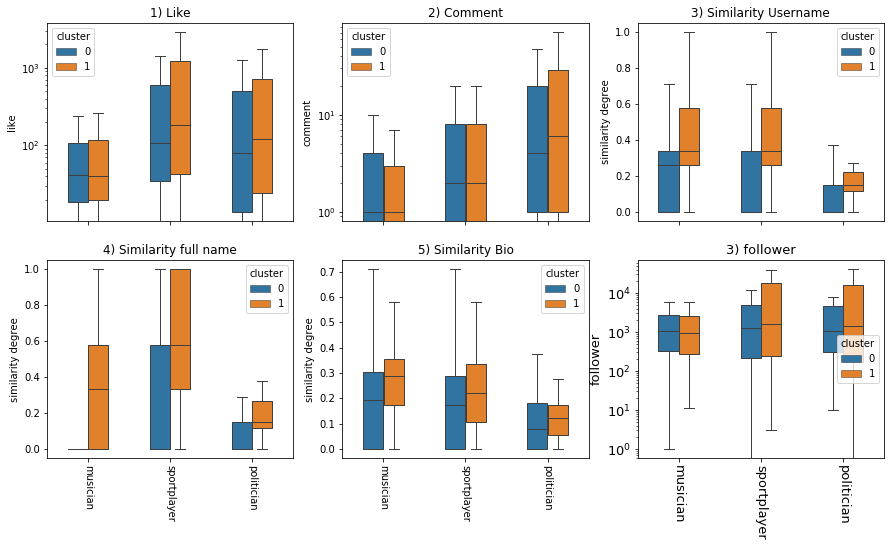

In [120]:
def plot_17():
    
    fig, axes= plt.subplots(2, 3, figsize=(15, 8))#, sharey=True)

#     grid = plt.GridSpec(4, 3, wspace=0.3, hspace=0.2)
#     first_plt = plt.subplot(grid[0, 0])
#     sec_plt = plt.subplot(grid[0, 1])
#     thirsd_plt = plt.subplot(grid[1, 2])
#     forth_plt = plt.subplot(grid[2, 3])


    df_cluster_1 = df_clusters_extended

    #     df_cluster_1 = remove_zero_df(df_cluster_1, 'emmanuelmacron')
    #     df_cluster_1[df_cluster_1['use case'] == 'emmanuelmacron']['sentiment_score'].replace(0, np.nan)

    #     print(df_cluster_1[df_cluster_1['use case'] == 'emmanuelmacron'])
    #     print(df_cluster_1[df_cluster_1['use case'] == 'emmanuelmacron']['sentiment_score'].replace(0,nan))

    sp = sns.boxplot(x='community', y="like", hue='cluster', data=df_cluster_1, ax=axes[0][0],showfliers=False, linewidth=1, width=0.5)    
#     sp.set_ylabel("Sentiment Score")
    sp.set_xlabel("")
    sp.set_title("1) Like")
    sp.xaxis.set_tick_params(rotation=-90)
    # sp.axes.set_ylim([-5,10])
    sp.set_yscale("log")
    sp.set(xticklabels=[])


    sp = sns.boxplot(x='community', y="comment",  hue='cluster', data=df_cluster_1, ax=axes[0][1], showfliers=False, linewidth=1, width=0.5)#,
#                           order=vr.LIST_POLITICIAN + vr.LIST_SPORTPLAYER + vr.LIST_MUSICIAN)


    # sp.set_ylabel("Sentiment Score")
    sp.set_ylabel("comment")
    sp.set_xlabel("")
    sp.set_title("2) Comment")
    sp.set_yscale("log")
    sp.xaxis.set_tick_params(rotation=-90)
    #     ax.axes.set_xlim([0,1])
    # sp.axes.set_ylim([-5,10])
    sp.set(xticklabels=[])


    sp = sns.boxplot(x='community', y="similarity_username", hue='cluster', data=df_cluster_1, ax=axes[0][2], showfliers=False, linewidth=1, width=0.5)#,
#                           order=vr.LIST_POLITICIAN + vr.LIST_SPORTPLAYER + vr.LIST_MUSICIAN)

    # sp.set_ylabel("Sentiment Score")
    sp.set_ylabel("similarity degree")
    sp.set_xlabel("")
    sp.set_title("3) Similarity Username")
#     sp.set_yscale("log")
    sp.xaxis.set_tick_params(rotation=-90)
    sp.set(xticklabels=[])
    
    
    sp = sns.boxplot(x='community', y="similarity_full_name", hue='cluster', data=df_cluster_1, ax=axes[1][0], showfliers=False, linewidth=1, width=0.5)#,
#                           order=vr.LIST_POLITICIAN + vr.LIST_SPORTPLAYER + vr.LIST_MUSICIAN)

    # sp.set_ylabel("Sentiment Score")
    sp.set_ylabel("similarity degree")
    sp.set_xlabel("")
    sp.set_title("4) Similarity full name")
#     sp.set_yscale("log")
    sp.xaxis.set_tick_params(rotation=-90)
#     sp.set(xticklabels=[])


    sp = sns.boxplot(x='community', y="similarity_biography", hue='cluster', data=df_cluster_1, ax=axes[1][1], showfliers=False, linewidth=1, width=0.5)#,
#                           order=vr.LIST_POLITICIAN + vr.LIST_SPORTPLAYER + vr.LIST_MUSICIAN)

    # sp.set_ylabel("Sentiment Score")
    sp.set_ylabel("similarity degree")
    sp.set_xlabel("")
    sp.set_title("5) Similarity Bio")
#     sp.set_yscale("log")
    sp.xaxis.set_tick_params(rotation=-90)
    
    
    sp = sns.boxplot(x='community', y="followers", hue='cluster', data=df_cluster_1, ax=axes[1][2], showfliers=False, linewidth=1, width=0.5)#,
#                           order=vr.LIST_POLITICIAN + vr.LIST_SPORTPLAYER + vr.LIST_MUSICIAN)

    # sp.set_ylabel("Sentiment Score")
    sp.set_ylabel("follower")
    sp.set_xlabel("")
    sp.set_title("3) follower")
    sp.set_yscale("log")
    sp.xaxis.set_tick_params(rotation=-90)
    
    
    ax = sp
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()): item.set_fontsize(13)

    plt.savefig("plot_17Cluster_P17.pdf", bbox_inches='tight')

plot_17() 

<Figure size 432x288 with 0 Axes>

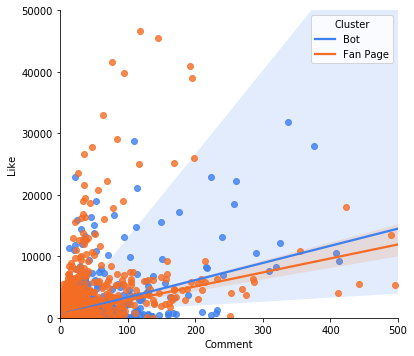

In [18]:
def plot_1():
    
    plt.figure()

    list_markers = [
        "h" , "X" , "v" , "o"
    ]
    
    ax = sns.lmplot(
        y="like", 
        x="comment", 
         hue="cluster",
        data=df_clusters_extended,  
        height=5, aspect=1.2, 
#         logistic=True, 
        x_jitter=2,
        palette={0:vr.COLOR_POLITICIAN, 1: vr.COLOR_SPORTSARTS},
        legend_out = False,
    )

    ax.set(ylim=(-1, 50000))
    ax.set(xlim=(-1, 500))

#     for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()): item.set_fontsize(18)
    
    plt.legend(title='Cluster', loc='upper right', labels=['Bot', 'Fan Page'])
    
    
#     ax.set(xscale="log", yscale="log")


    ax.set(xlabel='Comment', ylabel='Like')


    plt.savefig('plot_17Cluster_P1.pdf',bbox_inches='tight')
    plt.show(ax)
plot_1()

# Sentiment Analysis

In [19]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
np.random.seed(2018)
from gensim import corpora, models
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/koosha/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [20]:
df_clusters_extended.columns

Index(['user_id', 'caption', 'community', 'associated_username', 'cluster',
       'like', 'comment'],
      dtype='object')

In [21]:
df_clusters_extended = df_clusters_extended.dropna(subset=['caption'])
df_clusters_extended = df_clusters_extended[df_clusters_extended['caption'] != None]

In [22]:
nlp = spacy.load('en', parse = True, tag=True, entity=True)
#nlp_vec = spacy.load('en_vecs', parse = True, tag=True, entity=True)
tokenizer = ToktokTokenizer()
stopword_list = nltk.corpus.stopwords.words('english')
stopword_list.remove('no')
stopword_list.remove('not')

In [23]:
def clean_text(_row):
    
    text = _row['caption']
    
    text = re.sub(r'http\S+', '', text) # remove http links
    text = re.sub(r'bit.ly/\S+', '', text) # rempve bitly links
    text = text.strip('[link]') # remove [links]
    text = re.sub('\S*@\S*\s?', '', text)  # remove emails
    text = re.sub('\s+', ' ', text)  # remove newline chars
    text = re.sub("\'", "", text)  # remove single quotes

    #emojis
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)

    # Remove punctuation
    text = re.sub('[,\.!?]', '', text)

    # Convert the titles to lowercase
    text = text.lower()

    _row['caption_clean'] = text
        
    return _row

df_clusters_extended = df_clusters_extended.apply(clean_text, axis=1)

In [24]:
def remove_stopwords(_row):#, is_lower_case=False):
    
    is_lower_case = True
    text = _row['caption_clean']
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    
    _row['caption_clean_filtered'] = filtered_text
    return _row

df_clusters_extended = df_clusters_extended.apply(remove_stopwords, axis=1)

In [25]:
from nltk.stem import WordNetLemmatizer

def clean_text_v2(_row):
    
    stemmer = WordNetLemmatizer()
    
    document = _row['caption']
    
    # Remove all the special characters
    document = re.sub(r'\W', ' ', str(document))
    
    # remove all single characters
    document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)
    
    # Remove single characters from the start
    document = re.sub(r'\^[a-zA-Z]\s+', ' ', document) 
    
    # Substituting multiple spaces with single space
    document = re.sub(r'\s+', ' ', document, flags=re.I)
    
    # Removing prefixed 'b'
    document = re.sub(r'^b\s+', '', document)
    
    # Converting to Lowercase
    document = document.lower()
    
    # Lemmatization
    document = document.split()

    document = [stemmer.lemmatize(word) for word in document]
    document = ' '.join(document)
    
    _row['caption_clean_v2'] = document
        
    return _row

df_clusters_extended = df_clusters_extended.apply(clean_text_v2, axis=1)

In [26]:
# cleaned
corpus = df_clusters_extended['caption_clean'].tolist()

# corpus = df_clusters_extended['caption_clean_v2'].tolist()

# # emoticos
# corpus = df_all_post['post_caption'].tolist()

In [27]:
# initialize afinn sentiment analyzer
from afinn import Afinn
af = Afinn(emoticons=True)

# compute sentiment scores (polarity) and labels
sentiment_scores = [af.score(article) for article in corpus]
sentiment_category = ['positive' if score > 0 
                          else 'negative' if score < 0 
                              else 'neutral' 
                                  for score in sentiment_scores]
    
    
# sentiment statistics per news category
df = pd.DataFrame([ list(df_clusters_extended['associated_username']), list(df_clusters_extended['community']), list(df_clusters_extended['cluster']), sentiment_scores, sentiment_category]).T
df.columns = ['use case', 'community', 'cluster', 'sentiment_score', 'sentiment_category']
df['sentiment_score'] = df.sentiment_score.astype('float')
df
df.groupby(by=['cluster']).describe()

KeyboardInterrupt: 

In [ ]:
df.head()

In [ ]:
df.groupby(by=['cluster', 'community']).describe()

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

sp = sns.stripplot(x='community', y="sentiment_score", data=df, ax=ax1)

bp = sns.boxplot(x='community', y="sentiment_score", data=df, palette="Set2", ax=ax2, showfliers=False, linewidth=1,)

# bp.set_yscale('log')

t = f.suptitle('Visualizing News Sentiment', fontsize=14)

In [ ]:
def plot_3_2():
    
    fig = plt.subplots(1, 1, figsize=(10, 6), sharey=True)

    grid = plt.GridSpec(2, 3, wspace=0.4, hspace=0.2)
    first_plt = plt.subplot(grid[0, 0])
    sec_plt = plt.subplot(grid[0, 1:])

    df_cluster_1 = df[df['cluster'] == 0]

    sp = sns.stripplot(x='community', y="sentiment_score",dodge=True, data=df_cluster_1, ax=first_plt)
    sp.set_ylabel("Sentiment Score")
    sp.set_xlabel("")
    sp.set_title("1) Community")
    sp.xaxis.set_tick_params(rotation=-90)
    sp.axes.set_ylim([-40,80])
    
    ax = sp
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()): item.set_fontsize(15)


    sp = sns.stripplot(x='use case', y="sentiment_score", hue='community', dodge=True, data=df_cluster_1, ax=sec_plt,
                      order=vr.LIST_POLITICIAN + vr.LIST_SPORTPLAYER + vr.LIST_MUSICIAN)
    # sp.set_ylabel("Sentiment Score")
    sp.set_ylabel(" ")
    sp.set_xlabel("")
    sp.set_title("2) Use case")
    sp.xaxis.set_tick_params(rotation=-90)
#     ax.axes.set_xlim([0,1])
    sp.axes.set_ylim([-40,80])
    
    
    
    ax = sp
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()): item.set_fontsize(15)

    plt.savefig("plot_17clustering_P3_2.pdf", bbox_inches='tight')


plot_3_2()

In [ ]:
def plot_3_2_1():
    
    fig = plt.subplots(1, 1, figsize=(10, 6), sharey=True)

    grid = plt.GridSpec(2, 3, wspace=0.4, hspace=0.2)
    first_plt = plt.subplot(grid[0, 0])
    sec_plt = plt.subplot(grid[0, 1:])

    df_cluster_1 = df[df['cluster'] == 0]

    sp = sns.boxplot(x='community', y="sentiment_score",data=df_cluster_1, ax=first_plt,showfliers=False, linewidth=1, width=0.5)
#                                           order=["politician", "sportplayer", "musician"])
    
    ff = df_cluster_1.groupby('community')['sentiment_score'].mean()
    ff = ff.reindex(["musician", "sportplayer", "politician"])
    sp.plot(ff, 'rs')
    
    sp.set_ylabel("Sentiment Score")
    sp.set_xlabel("")
    sp.set_title("1) Community")
    sp.xaxis.set_tick_params(rotation=-90)
    sp.axes.set_ylim([-5,10])
    sp.set(xticklabels=[])
    
    ax = sp
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()): item.set_fontsize(15)


    sp = sns.boxplot(x='use case', y="sentiment_score", hue='community',data=df_cluster_1, ax=sec_plt, showfliers=False, linewidth=1,
                      order=vr.LIST_POLITICIAN + vr.LIST_SPORTPLAYER + vr.LIST_MUSICIAN)
    
    ff = df_cluster_1.groupby('use case')['sentiment_score'].mean()
    ff = ff.reindex(vr.LIST_POLITICIAN + vr.LIST_SPORTPLAYER + vr.LIST_MUSICIAN)
    sp.plot(ff, 'rs')
    
    # sp.set_ylabel("Sentiment Score")
    sp.set_ylabel(" ")
    sp.set_xlabel("")
    sp.set_title("2) Use case")
    sp.xaxis.set_tick_params(rotation=-90)
#     ax.axes.set_xlim([0,1])
    sp.axes.set_ylim([-5,10])
    sp.set(xticklabels=[])
    
    
    ax = sp
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()): item.set_fontsize(15)

    plt.savefig("plot_17clustering_P3_2_1.pdf", bbox_inches='tight')


plot_3_2_1()

In [ ]:
def plot_3_3_1():
    
    fig = plt.subplots(1, 1, figsize=(10, 6))#, sharey=True)

    grid = plt.GridSpec(2, 3, wspace=0.4, hspace=0.2)
    first_plt = plt.subplot(grid[0, 0])
    sec_plt = plt.subplot(grid[0, 1:])

    df_cluster_1 = df[df['cluster'] == 1]

    sp = sns.boxplot(x='community', y="sentiment_score",data=df_cluster_1, ax=first_plt, showfliers=False, linewidth=1, width=0.5)
#                      order=["politician", "sportplayer", "musician"])
    
    ff = df_cluster_1.groupby('community')['sentiment_score'].mean()
    ff = ff.reindex(["musician", "sportplayer", "politician"])
    sp.plot(ff, 'rs')
    
    sp.set_ylabel("Sentiment Score")
    sp.set_xlabel("")
    sp.set_title("3) Community")
    sp.xaxis.set_tick_params(rotation=-90)
    sp.axes.set_ylim([-5,10])
    
    ax = sp
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()): item.set_fontsize(15)


    sp = sns.boxplot(x='use case', y="sentiment_score", hue='community',data=df_cluster_1, ax=sec_plt, showfliers=False, linewidth=1, 
                      order=vr.LIST_POLITICIAN + vr.LIST_SPORTPLAYER + vr.LIST_MUSICIAN)
    
    ff = df_cluster_1.groupby('use case')['sentiment_score'].mean()
    ff = ff.reindex(vr.LIST_POLITICIAN + vr.LIST_SPORTPLAYER + vr.LIST_MUSICIAN)
    sp.plot(ff, 'rs')
    
    # sp.set_ylabel("Sentiment Score")
    sp.set_ylabel(" ")
    sp.set_xlabel("")
    sp.set_title("4) Use case")
    sp.xaxis.set_tick_params(rotation=-90)
    
    sp.legend().remove()
#     ax.axes.set_xlim([0,1])
    sp.axes.set_ylim([-5,10])
#     sp.set_yscale("log")
    
    
    ax = sp
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()): item.set_fontsize(15)

    plt.savefig("plot_17clustering_P3_3_1.pdf", bbox_inches='tight')


plot_3_3_1()

In [ ]:
def plot_4():
    
    sns.set(style="whitegrid")
#     sns.set(style="whitegrid")
#     sborn.set(font_scale=1.5)
    
    
#     f, axes = plt.subplots(1, 1, figsize=(5, 4))#, sharey=True)

#     color = {NAME_CLUSTER_0: COLOR_C0, NAME_CLUSTER_1: COLOR_C1, NAME_CLUSTER_2:COLOR_C2}
    
    fc = sns.factorplot(x="community", hue="sentiment_category",
                        col="cluster",
                        data=df, kind="count", 
                        legend=True,
                        palette={"negative": "#FE2020", 
                             "positive": "#BADD07", 
                             "neutral": "#68BFF5"})

    axes = fc.axes.flatten()
    axes[0].set_ylabel("Caption/Post Count")
#     axes[0].set_xlabel("")
    
#     fc.set_title("")
#     axes[0].xaxis.set_tick_params(rotation=-45)
    

    fc.fig.get_axes()[0].set_yscale('log')
    
    for ax in fc.axes.flat:
        for label in ax.get_yticklabels():
            label.set_fontsize(14)
            
        for label in ax.get_xticklabels():
            label.set_fontsize(14)
    plt.savefig("plot_17clustering_P4.pdf", bbox_inches='tight')

    # fc.set_yscale('log')
    
plot_4()

In [ ]:
# def plot_4_2():
    
#     sns.set(style="whitegrid")
    
#     f, axes = plt.subplots(1, 3, figsize=(18, 4), sharey=True)

#     df_cluster_0 = df[df['cluster'] == 1]
    
#     df_grouped = df_cluster_0.groupby(['community',  'use case', 'sentiment_category',])['sentiment_score'].size().reset_index(name='counts')
    
#     counter = 0
#     for name, group in df_grouped.groupby('community'):

#         ax = sns.barplot(x="use case", 
#                          y="counts", 
#                          hue='sentiment_category', 
#                          data=group, 
#                          palette={"negative": "#FE2020", 
#                                      "positive": "#BADD07", 
#                                      "neutral": "#68BFF5"},
#                          ax=axes[counter]
#                         )



#         ax.set_yscale('log')
#         ax.xaxis.set_tick_params(rotation=-90)
#         ax.set_xlabel("")
#         ax.set_ylabel("")

#         counter +=1

#     axes[0].set_ylabel("Post/Caption Count")
#     axes[0].set_xlabel("A) Musician")
#     axes[1].set_xlabel("B) Politician")
#     axes[2].set_xlabel("C) Sport Player")

#     for ax in axes:
#         for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()): item.set_fontsize(15)
            
#     plt.savefig("plot_17clustering_P4_2.pdf", bbox_inches='tight')
    
# plot_4_2()

In [ ]:
df.head()

In [ ]:
def plot_5():
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 4))#, sharey=True)
    
    df_cluster_0 = df[df['cluster'] == 0]
#     df_grouped = df_cluster_0.groupby(['community',  'use case', 'sentiment_category',])['sentiment_score'].size().reset_index(name='counts')
    
    

    bp = sns.boxplot(x='use case', y="sentiment_score", hue='community', data=df_cluster_0, ax=ax1, showfliers=False, linewidth=1,
                    order=vr.LIST_POLITICIAN + vr.LIST_SPORTPLAYER + vr.LIST_MUSICIAN
                    )
    
#     bp.plot(df_clusters_extended.mean(), 'rs')
    bp.set_ylabel("Sentiment Score")
    bp.set_xlabel("")
    bp.set_title("")
    bp.xaxis.set_tick_params(rotation=-90)
    bp.legend().remove()
    

    df_cluster_1 = df[df['cluster'] == 1]
    bp = sns.boxplot(x='use case', y="sentiment_score", hue='community', data=df_cluster_1, ax=ax2, showfliers=False, linewidth=1,
                    order=vr.LIST_POLITICIAN + vr.LIST_SPORTPLAYER + vr.LIST_MUSICIAN
                    )
    
#     bp.plot(df_clusters_extended.mean(), 'rs')
    bp.set_ylabel("Sentiment Score")
    bp.set_xlabel("")
    bp.set_title("")
    bp.xaxis.set_tick_params(rotation=-90)
#     bp.legend().remove()

    
plot_5()

# Method 2

In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

In [ ]:
def get_vader_sentiment(_row):
    temp = _row['caption_clean_v2']
    _row['vader'] = analyzer.polarity_scores(temp)
    return _row

df_clusters_extended = df_clusters_extended.apply(get_vader_sentiment, axis=1)

In [ ]:
def extend_vader(_row):
    
    item = _row['vader']
    
    _row['vader_pos'] = item['pos']
    _row['vader_neu'] = item['neu']
    _row['vader_neg'] = item['neg']
    _row['vader_compound'] = item['compound']
    
    return _row

df_clusters_extended = df_clusters_extended.apply(extend_vader, axis=1)

In [ ]:
def transform_compound_to_cat(_row):    

    if _row["vader_compound"] >= 0.05:
        _row['vader_cat'] = "positive"
        
    elif _row["vader_compound"] <= -0.05:
        _row['vader_cat'] = "negative"
        
    else:
        _row['vader_cat'] = "neutral"
    
    return _row

df_clusters_extended = df_clusters_extended.apply(transform_compound_to_cat, axis=1)

In [ ]:
grouped_df_clusters_extended = df_clusters_extended.groupby('cluster')
cluster_0 = grouped_df_clusters_extended.get_group(0)
cluster_1 = grouped_df_clusters_extended.get_group(1)

In [ ]:
cluster_0[['caption', 'vader_pos', 'vader_neu', 'vader_neg', 'vader_compound', 'vader_cat']].head()

In [ ]:
def get_points(_df):
    
    list_vader = _df['vader'].tolist()
    points = []
    
    for item in list_vader:
        x = item['pos']
        y = item['neu']
        z = item['neg']
        points.append((x,y,z))
        
    return points

In [ ]:
import ternary
import random

def plot_7():

    scale = 1
    fig, tax = ternary.figure(scale=1.0)
    fig.set_size_inches(8, 8)


    # Draw Boundary and Gridlines
    tax.boundary(linewidth=0.5, alpha=0.5)
    tax.gridlines(color="blue", multiple=5)

    # Set Axis labels and Title
    fontsize = 18
    offset = 0.24

    # tax.right_corner_label("X", fontsize=fontsize)
    # tax.top_corner_label("Y", fontsize=fontsize)
    # tax.left_corner_label("Z", fontsize=fontsize)

    tax.left_axis_label("Negative", fontsize=fontsize, offset=offset)
    tax.right_axis_label("Neutral", fontsize=fontsize, offset=offset)
    tax.bottom_axis_label("Positive", fontsize=fontsize, offset=offset)

    n_size = 50
    ["h" , "X" , "v" , "o"]

    points = get_points(cluster_1)
    tax.scatter(points, marker='h', s=n_size, color=vr.COLORS_CLUSTERS[0], label="Fan Page", alpha=0.8)

    points = get_points(cluster_0)
    tax.scatter(points, marker='v', s=n_size, color=vr.COLOR_SPORTSARTS, label="Bot", alpha=0.5)



    tax.legend()


    # tax.boundary(linewidth=1.0)
    tax.gridlines(multiple=0.1, color="gray")
    tax.clear_matplotlib_ticks()
    tax.ticks(axis='lbr', linewidth=1, multiple=0.1, tick_formats="%.1f", offset=0.035)

    tax.get_axes().axis('off')

    tax.show()

    fig.savefig("plot_17Clustering_P7.pdf", bbox_inches='tight')

plot_7()

In [ ]:
import ternary
import random

def plot_7_1():

    scale = 1
    fig, tax = ternary.figure(scale=1.0)
    fig.set_size_inches(8, 8)


    # Draw Boundary and Gridlines
    tax.boundary(linewidth=0.5, alpha=0.5)
    tax.gridlines(color="blue", multiple=5)

    # Set Axis labels and Title
    fontsize = 12
    offset = 0.24

    # tax.right_corner_label("X", fontsize=fontsize)
    # tax.top_corner_label("Y", fontsize=fontsize)
    # tax.left_corner_label("Z", fontsize=fontsize)

    tax.left_axis_label("Negative", fontsize=fontsize, offset=offset)
    tax.right_axis_label("Neutral", fontsize=fontsize, offset=offset)
    tax.bottom_axis_label("Positive", fontsize=fontsize, offset=offset)

    n_size = 50
    ["h" , "X" , "v" , "o"]

#     points = get_points(cluster_1)
#     tax.scatter(points, marker='h', s=n_size, color=vr.COLORS_CLUSTERS[0], label="Bot", alpha=0.3)

    points = get_points(cluster_0)
    tax.scatter(points, marker='v', s=n_size, color=vr.COLORS_CLUSTERS[1], label="Fan Page", alpha=0.3)



    tax.legend()


    # tax.boundary(linewidth=1.0)
    tax.gridlines(multiple=0.1, color="gray")
    tax.clear_matplotlib_ticks()
    tax.ticks(axis='lbr', linewidth=1, multiple=0.1, tick_formats="%.1f", offset=0.035)

    tax.get_axes().axis('off')

    tax.show()

    fig.savefig("plot_17Clustering_P7_!.pdf", bbox_inches='tight')

plot_7_1()

In [ ]:
from pandas import DataFrame
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [ ]:
def get_ternary_data(_df, _n_cluster):
    
    Data = get_points(_df) 
    df = DataFrame(Data,columns=['x','y','z'])

    # kmeans
    n_cluster = _n_cluster
    kmeans = KMeans(n_clusters=n_cluster).fit(df)
    centroids = kmeans.cluster_centers_

    df['cluster'] = kmeans.labels_


    # cluster df
    df_clusters = pd.DataFrame(kmeans.cluster_centers_)
    df_clusters.columns = ['x', 'y', 'z']

    list_lens = []
    cluster_sizes = df.groupby(['cluster']).size()
    for name, group in df.groupby(['cluster']):
        list_lens.append(group.shape[0])

    df_clusters['size'] = list_lens
    return centroids, df_clusters



In [ ]:
def plot_8():
    scale = 1
    fig, tax = ternary.figure(scale=1.0)
    fig.set_size_inches(8, 8)


    # Draw Boundary and Gridlines
    tax.boundary(linewidth=0.5, alpha=0.5)
    tax.gridlines(color="blue", multiple=5)

    # Set Axis labels and Title
    fontsize = 15
    offset = 0.24
    node_constant = 9

    # tax.right_corner_label("X", fontsize=fontsize)
    # tax.top_corner_label("Y", fontsize=fontsize)
    # tax.left_corner_label("Z", fontsize=fontsize)

    tax.left_axis_label("Negative", fontsize=fontsize, offset=offset)
    tax.right_axis_label("Neutral", fontsize=fontsize, offset=offset)
    tax.bottom_axis_label("Positive", fontsize=fontsize, offset=offset)

    n_size = 5
    ["h" , "X" , "v" , "o"]

    cluster_size = 50

    centroids_clusters, df_data_clusters = get_ternary_data(cluster_0, cluster_size)
    sizes = [math.log(num)**2 * node_constant for num in df_data_clusters['size']]
    tax.scatter(centroids_clusters, marker='v', s=sizes, color=vr.COLORS_CLUSTERS[0], label="Cluster 0", alpha=0.7)

    centroids_clusters, df_data_clusters = get_ternary_data(cluster_1, cluster_size)
    sizes = [math.log(num)**2 * node_constant for num in df_data_clusters['size']]
    tax.scatter(centroids_clusters, marker='o', s=sizes, color=vr.COLORS_CLUSTERS[1], label="Cluster 1", alpha=0.5)

#     centroids_clusters, df_data_clusters = get_ternary_data(df_post_politician, cluster_size)
#     sizes = [ye.count(num)**2.5 * node_constant for num in df_data_clusters['size']]
#     tax.scatter(centroids_clusters, marker='v', s=sizes, color=vr.COLOR_POLITICIAN, label="Politician", alpha=0.6)

    tax.legend()


    # tax.boundary(linewidth=1.0)
    tax.gridlines(multiple=0.1, color="gray")
    tax.clear_matplotlib_ticks()
    tax.ticks(axis='lbr', linewidth=1, multiple=0.1, tick_formats="%.1f", offset=0.04)

    tax.get_axes().axis('off')

    tax.show()

    fig.savefig("plot_17Clustering_P8.pdf", bbox_inches='tight')
    
plot_8()

In [ ]:
df_clusters_extended.columns

In [ ]:
def plot_9():
    
    f, axes = plt.subplots(1, 1, figsize=(8, 4))#, sharey=True)

#     color = {NAME_CLUSTER_0: COLOR_C0, NAME_CLUSTER_1: COLOR_C1, NAME_CLUSTER_2:COLOR_C2}
    
    sp = sns.stripplot(x='associated_username', y="vader_compound", hue='community', dodge=True, data=df_clusters_extended, ax=axes,
                      order=vr.LIST_POLITICIAN + vr.LIST_SPORTPLAYER + vr.LIST_MUSICIAN
                      
                      )
    sp.set_ylabel("Sentiment Score")
    sp.set_xlabel("")
    sp.set_title("")
    sp.xaxis.set_tick_params(rotation=-90)

#     #     for ax in axes:
#     ax = sp
#     for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()): item.set_fontsize(15)

#     plt.savefig("plot_17clustering_P9.pdf", bbox_inches='tight')

#     print("Sentiment score for all comment issued by impersonator across communities")
    # t = f.suptitle('Visualizing News Sentiment', fontsize=14)
    
plot_9()

In [ ]:
def plot_9_1():
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))#, sharey=True)

#     color = {NAME_CLUSTER_0: COLOR_C0, NAME_CLUSTER_1: COLOR_C1, NAME_CLUSTER_2:COLOR_C2}
#                         (x='use case', y="sentiment_score", hue='community', dodge=True, data=df, ax=ax1)
    sp = sns.stripplot(x='associated_username', y="vader_compound", hue='community', dodge=True, data=df_clusters_extended, ax=ax1,
                      order=vr.LIST_POLITICIAN + vr.LIST_SPORTPLAYER + vr.LIST_MUSICIAN
                      
                      )
    sp.set_ylabel("Sentiment Score")
    sp.set_xlabel("")
    sp.set_title("")
    sp.xaxis.set_tick_params(rotation=-90)
    

    bp = sns.boxplot(x='associated_username', y="vader_compound", hue='community', data=df_clusters_extended, ax=ax2, showfliers=False, linewidth=1,
                    order=vr.LIST_POLITICIAN + vr.LIST_SPORTPLAYER + vr.LIST_MUSICIAN
                    )
#     bp.plot(df_clusters_extended.mean(), 'rs')
    bp.set_ylabel("Sentiment Score")
    bp.set_xlabel("")
    bp.set_title("")
    bp.xaxis.set_tick_params(rotation=-90)
    bp.legend().remove()

#     plt.savefig("plot_05post_topic_P3.pdf", bbox_inches='tight')

#     print("Sentiment score for all comment issued by impersonator across communities")
    # t = f.suptitle('Visualizing News Sentiment', fontsize=14)
    
plot_9_1()

In [ ]:
def plot_9_2():
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))#, sharey=True)

    bp = sns.boxplot(x='associated_username', y="vader_compound", hue='community', data=cluster_0, ax=ax1, showfliers=False, linewidth=1,
                    order=vr.LIST_POLITICIAN + vr.LIST_SPORTPLAYER + vr.LIST_MUSICIAN
                    )
    
#     bp.plot(df_clusters_extended.mean(), 'rs')
    bp.set_ylabel("Sentiment Score")
    bp.set_xlabel("")
    bp.set_title("")
    bp.xaxis.set_tick_params(rotation=-90)
    bp.legend().remove()
    

    bp = sns.boxplot(x='associated_username', y="vader_compound", hue='community', data=cluster_1, ax=ax2, showfliers=False, linewidth=1,
                    order=vr.LIST_POLITICIAN + vr.LIST_SPORTPLAYER + vr.LIST_MUSICIAN
                    )
    
#     bp.plot(df_clusters_extended.mean(), 'rs')
    bp.set_ylabel("Sentiment Score")
    bp.set_xlabel("")
    bp.set_title("")
    bp.xaxis.set_tick_params(rotation=-90)
    bp.legend().remove()

    
plot_9_2()

In [ ]:
def plot_10():
    
    sns.set(style="whitegrid")
#     sns.set(style="whitegrid")
#     sborn.set(font_scale=1.5)
    
    
#     f, axes = plt.subplots(1, 1, figsize=(5, 4))#, sharey=True)

#     color = {NAME_CLUSTER_0: COLOR_C0, NAME_CLUSTER_1: COLOR_C1, NAME_CLUSTER_2:COLOR_C2}
    
    fc = sns.factorplot(x="community", hue="vader_cat",
                        col="cluster",
                        data=df_clusters_extended, kind="count", 
                        legend=True,
#                         palette={"negative": "#FE2020", 
#                              "positive": "#BADD07", 
#                              "neutral": "#68BFF5"}
                       )

    axes = fc.axes.flatten()
    axes[0].set_ylabel("Caption/Post Count")
#     axes[0].set_xlabel("")
    
#     fc.set_title("")
#     axes[0].xaxis.set_tick_params(rotation=-45)
    

    fc.fig.get_axes()[0].set_yscale('log')
    
    for ax in fc.axes.flat:
        for label in ax.get_yticklabels():
            label.set_fontsize(14)
            
        for label in ax.get_xticklabels():
            label.set_fontsize(14)
#     plt.savefig("plot_17clustering_P4.pdf", bbox_inches='tight')

    # fc.set_yscale('log')
    
plot_10()

In [ ]:
df = df_clusters_extended.groupby(['cluster', 'community', 'vader_cat']).size().reset_index(name='Size')
df

In [ ]:
def normalize_value(_value, _min, _max):
    _norm = (_value - _min) / (_max - _min)
    return _norm


sizee = df[(df['cluster'] == 1) & (df['community'] == 'sportplayer')]['Size'].sum()
normalize_value(426, 0, sizee)

In [ ]:
def calculater_normalized(_row):
    
    sizee = df[  (df['cluster'] == _row['cluster']) 
               & (df['community'] == _row['community'])]['Size'].sum()

    
    _row['n_size'] = normalize_value(_row['Size'], 0, sizee)
    return _row

df = df.apply(calculater_normalized, axis=1)

In [ ]:
df

In [ ]:
def plot_11():
    
    sns.set(style="whitegrid")    

    f, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
    
    df_0 = df[df['cluster'] == 0]
    df_1 = df[df['cluster'] == 1]
    
    ax = sns.barplot(x="community", y="n_size", hue="vader_cat", data=df_0, ax=axes[0])
#     ax.set_yscale("log")
    
    ax = sns.barplot(x="community", y="n_size", hue="vader_cat", data=df_1, ax=axes[1])
#     ax.set_yscale("log")

#     plt.savefig("plot_17clustering_P4.pdf", bbox_inches='tight')

    # fc.set_yscale('log')
    
plot_11()